# Used in this kernel:
* preprocessed dataset by olivier https://www.kaggle.com/ogrellier/create-extracted-json-fields-dataset
* exported google analytics data https://www.kaggle.com/satian/exported-google-analytics-data


* story of a leak v.01 https://www.kaggle.com/igauty/story-of-a-leak-v01
* future is here https://www.kaggle.com/ashishpatel26/future-is-here
* teach-lightgbm-to-sum-predictions https://www.kaggle.com/satian/story-of-a-leak/notebook


The code below is full of bugs, which I didn't remove as they seem to improve LB.

In [1]:
import pandas as pd
import numpy as np

# DRAGONS
import xgboost as xgb
import lightgbm as lgb
import catboost as cat

# plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import json
# import bq_helper
from pandas.io.json import json_normalize

# pandas / plt options
pd.options.display.max_columns = 999
plt.rcParams['figure.figsize'] = (14, 7)
font = {'family' : 'verdana',
        'weight' : 'bold',
        'size'   : 14}
plt.rc('font', **font)

# remove warnings
import warnings
warnings.simplefilter("ignore")

from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm
tqdm.pandas()

# garbage collector
import gc
gc.enable()

/Users/rick/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Loading data

In [2]:
# https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields
input_file_path = '/Users/rick/Dropbox/python_projects/data_science/Kaggle/GA_customer_revenue_prediction/input'

def load_df(csv_path=input_file_path + '/train.csv', JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource'], load_all=False):
    if not load_all:
        df = pd.read_csv(csv_path, 
                         converters={column: json.loads for column in JSON_COLUMNS}, 
                         dtype={'fullVisitorId': 'str'}, nrows=300000)
    else:
        df = pd.read_csv(csv_path, 
                         converters={column: json.loads for column in JSON_COLUMNS}, 
                         dtype={'fullVisitorId': 'str'})
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

    return df

In [3]:
%%time
train = load_df(input_file_path + "/train_v2.csv.zip")

CPU times: user 60 s, sys: 3.62 s, total: 1min 3s
Wall time: 1min 3s


In [4]:
%%time
test = load_df(input_file_path + "/test_v2.csv.zip", load_all=True)

CPU times: user 1min 36s, sys: 5.87 s, total: 1min 42s
Wall time: 1min 43s


In [5]:
# test['totals'].apply(lambda t: float(dict(eval(t))['transactionRevenue']))

KeyError: 'totals'

In [6]:
train.columns

Index(['channelGrouping', 'customDimensions', 'date', 'fullVisitorId', 'hits',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserSize', 'device.browserVersion',
       'device.deviceCategory', 'device.flashVersion', 'device.isMobile',
       'device.language', 'device.mobileDeviceBranding',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.screenColors', 'device.screenResolution', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.networkLocation',
       'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces',
       'totals.hits', 'totals.newVisits', 'totals.pageviews',
       'totals.ses

In [7]:
train.columns

Index(['channelGrouping', 'customDimensions', 'date', 'fullVisitorId', 'hits',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserSize', 'device.browserVersion',
       'device.deviceCategory', 'device.flashVersion', 'device.isMobile',
       'device.language', 'device.mobileDeviceBranding',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.screenColors', 'device.screenResolution', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.networkLocation',
       'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces',
       'totals.hits', 'totals.newVisits', 'totals.pageviews',
       'totals.ses

In [9]:
# some data processing
train['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True, inplace=True)
test['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True, inplace=True)
train['trafficSource.isTrueDirect'].fillna(False, inplace=True)
test['trafficSource.isTrueDirect'].fillna(False, inplace=True)

train['date'] = pd.to_datetime(train['date'].apply(lambda x: str(x)[:4] + '-' + str(x)[4:6] + '-' + str(x)[6:]))
test['date'] = pd.to_datetime(test['date'].apply(lambda x: str(x)[:4] + '-' + str(x)[4:6] + '-' + str(x)[6:]))

In [10]:
cols_to_drop = [col for col in train.columns if train[col].nunique(dropna=False) == 1]
train.drop(cols_to_drop, axis=1, inplace=True)
test.drop([col for col in cols_to_drop if col in test.columns], axis=1, inplace=True)

#only one not null value
# train.drop(['trafficSource.campaignCode'], axis=1, inplace=True)
# test.drop(['trafficSource.campaignCode'], axis=1, inplace=True)

print(f'Dropped {len(cols_to_drop)} columns.')

Dropped 19 columns.


In [11]:
test.head()

,channelGrouping,customDimensions,date,fullVisitorId,hits,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.totalTransactionRevenue,totals.transactionRevenue,totals.transactions,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,"[{'index': '4', 'value': 'APAC'}]",2018-05-11,7460955084541987166,"[{'hitNumber': '1', 'time': '0', 'hour': '21',...",1526099341,2,1526099341,Chrome,mobile,True,Android,(not set),Asia,India,(not set),unknown.unknown,Delhi,Southern Asia,NaN,4,NaN,3,1,973,NaN,NaN,NaN,(not set),NaN,NaN,True,NaN,NaN,(not set),True,(not provided),organic,(not set),google
1,Direct,"[{'index': '4', 'value': 'North America'}]",2018-05-11,460252456180441002,"[{'hitNumber': '1', 'time': '0', 'hour': '11',...",1526064483,166,1526064483,Chrome,desktop,False,Macintosh,San Francisco,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,NaN,4,NaN,3,1,49,NaN,NaN,NaN,(not set),NaN,NaN,True,NaN,NaN,(not set),True,(not set),(none),(not set),(direct)
2,Organic Search,"[{'index': '4', 'value': 'North America'}]",2018-05-11,3461808543879602873,"[{'hitNumber': '1', 'time': '0', 'hour': '12',...",1526067157,2,1526067157,Chrome,desktop,False,Chrome OS,not available in demo dataset,Americas,United States,not available in demo dataset,onlinecomputerworks.com,not available in demo dataset,Northern America,NaN,4,NaN,3,1,24,NaN,NaN,NaN,(not set),NaN,NaN,True,NaN,NaN,(not set),True,(not provided),organic,(not set),google
3,Direct,"[{'index': '4', 'value': 'North America'}]",2018-05-11,975129477712150630,"[{'hitNumber': '1', 'time': '0', 'hour': '23',...",1526107551,4,1526107551,Chrome,mobile,True,iOS,Houston,Americas,United States,Houston TX,(not set),Texas,Northern America,NaN,5,NaN,4,1,25,NaN,NaN,NaN,(not set),NaN,NaN,True,NaN,NaN,(not set),True,(not set),(none),(not set),(direct)
4,Organic Search,"[{'index': '4', 'value': 'North America'}]",2018-05-11,8381672768065729990,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",1526060254,1,1526060254,Internet Explorer,tablet,True,Windows,Irvine,Americas,United States,Los Angeles CA,com,California,Northern America,NaN,5,1,4,1,49,NaN,NaN,NaN,(not set),NaN,NaN,True,NaN,NaN,(not set),False,(not provided),organic,(not set),google


In [12]:
# converting columns into more reasonable format
for col in ['visitNumber', 'totals.hits', 'totals.pageviews', 'totals.transactionRevenue']:
    train[col] = train[col].astype(float)

In [13]:
train.drop(['customDimensions', 'hits', 'trafficSource.referralPath', 'trafficSource.source', 'totals.totalTransactionRevenue'], axis=1, inplace=True)
test.drop(['customDimensions', 'hits', 'trafficSource.referralPath', 'trafficSource.source', 'totals.totalTransactionRevenue'], axis=1, inplace=True)

In [14]:
for col in train.columns:
    if train[col].isnull().sum() > 0:
        rate = train[col].isnull().sum() * 100 / train.shape[0]
        print(f'Column {col} has {rate:.4f}% missing values.')
    if train[col].dtype == 'object':
        if (train[col] == 'not available in demo dataset').sum() > 0:
            rate = (train[col] == 'not available in demo dataset').sum() * 100 / train.shape[0]
            print(f'Column {col} has {rate:.4f}% values not available in dataset.')

Column geoNetwork.city has 54.5520% values not available in dataset.
Column geoNetwork.metro has 54.5520% values not available in dataset.
Column geoNetwork.region has 54.5520% values not available in dataset.
Column totals.bounces has 48.4557% missing values.
Column totals.newVisits has 22.8260% missing values.
Column totals.pageviews has 0.0130% missing values.
Column totals.sessionQualityDim has 53.3087% missing values.
Column totals.timeOnSite has 51.7020% missing values.
Column totals.transactionRevenue has 98.9487% missing values.
Column totals.transactions has 98.9443% missing values.
Column trafficSource.adContent has 96.0480% missing values.
Column trafficSource.adwordsClickInfo.adNetworkType has 95.3547% missing values.
Column trafficSource.adwordsClickInfo.gclId has 95.3353% missing values.
Column trafficSource.adwordsClickInfo.page has 95.3547% missing values.
Column trafficSource.adwordsClickInfo.slot has 95.3547% missing values.
Column trafficSource.campaignCode has 99.99

# Looking around

Some pictures to have in mind: target distribution

In [15]:
target_sums = train.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

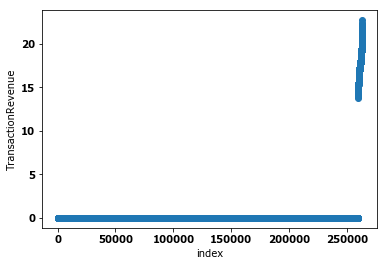

In [16]:
plt.scatter(range(target_sums.shape[0]), np.sort(np.log1p(target_sums["totals.transactionRevenue"].values)))
plt.xlabel('index')
plt.ylabel('TransactionRevenue')
plt.show()

Key problem:

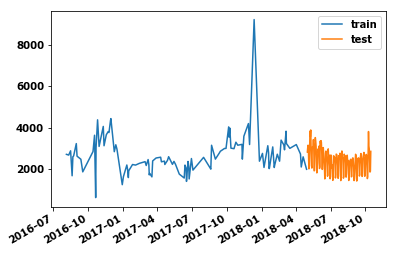

In [17]:
train.date = pd.to_datetime(train.date, format="%Y%m%d")
test.date = pd.to_datetime(test.date, format="%Y%m%d")
train.date.value_counts().sort_index().plot(label="train")
test.date.value_counts().sort_index().plot(label="test")
plt.legend()

Comparing categories in train and test:

In [18]:
train.date

0        2017-10-16
1        2017-10-16
2        2017-10-16
3        2017-10-16
4        2017-10-16
5        2017-10-16
6        2017-10-16
7        2017-10-16
8        2017-10-16
9        2017-10-16
10       2017-10-16
11       2017-10-16
12       2017-10-16
13       2017-10-16
14       2017-10-16
15       2017-10-16
16       2017-10-16
17       2017-10-16
18       2017-10-16
19       2017-10-16
20       2017-10-16
21       2017-10-16
22       2017-10-16
23       2017-10-16
24       2017-10-16
25       2017-10-16
26       2017-10-16
27       2017-10-16
28       2017-10-16
29       2017-10-16
            ...    
299970   2016-10-21
299971   2016-10-21
299972   2016-10-21
299973   2016-10-21
299974   2016-10-21
299975   2016-10-21
299976   2016-10-21
299977   2016-10-21
299978   2016-10-21
299979   2016-10-21
299980   2016-10-21
299981   2016-10-21
299982   2016-10-21
299983   2016-10-21
299984   2016-10-21
299985   2016-10-21
299986   2016-10-21
299987   2016-10-21
299988   2016-10-21


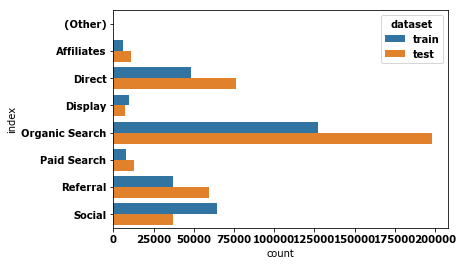

In [19]:
def drawBars(columnname):
    sns.barplot(x="count", y="index", hue="dataset",
        data=pd.melt(pd.concat([train[columnname].value_counts().rename("train"), 
                       test[columnname].value_counts().rename("test")], axis=1, sort="False").reset_index(),
            id_vars="index", var_name="dataset", value_name="count"))

drawBars("channelGrouping")

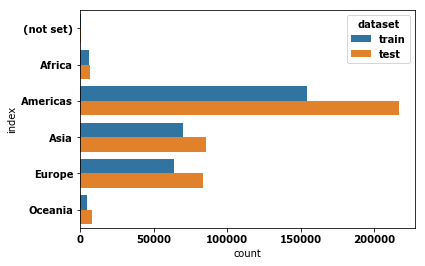

In [20]:
drawBars("geoNetwork.continent")

In [21]:
ids_train = set(train.fullVisitorId.unique())
ids_test = set(test.fullVisitorId.unique())
print("Unique visitor ids in train:", len(ids_train))
print("Unique visitor ids in test:", len(ids_test))
print("Common visitors in train and test:", len(ids_train & ids_test))

Unique visitor ids in train: 262777
Unique visitor ids in test: 296530
Common visitors in train and test: 1013


Weird "double" sessions:


VisitStartTime seems to be same thing as visitId... yet not always!

In [23]:
(train.visitStartTime == train.visitId).value_counts()

True     298558
False      1442
dtype: int64

Suspicious simultaneous visitors with same visitorId and same visitStartTime:

In [24]:
train.loc[pd.to_datetime(train.visitStartTime, unit='s') == "2017-04-25 18:49:35"].head(8)

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.transactionRevenue,totals.transactions,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium


Seems to be a serious problem:

In [25]:
# bincount: 負でない整数の配列の各値の出現回数をカウント
print("Train: ", np.bincount(train.visitId.value_counts()))

Train:  [     0 283283   5722    235     50     33     26     20     14     17
     24     12     15     24     22     24     19     21     21     23
      9      8      5      2      2      0      1      0      2]


In [26]:
print("test: ", np.bincount(test.visitId.value_counts()))

test:  [     0 385311   7470    312     59     16      7      5      0      1]


# Preprocessing

Setting time as index and saving time as feature (for FE purposes only)

In [27]:
train.visitStartTime = pd.to_datetime(train.visitStartTime, unit='s')
test.visitStartTime = pd.to_datetime(test.visitStartTime, unit='s')
train["date"] = train.visitStartTime
test["date"] = test.visitStartTime

In [28]:
train.set_index("visitStartTime", inplace=True)
test.set_index("visitStartTime", inplace=True)
train.sort_index(inplace=True)
test.sort_index(inplace=True)

Clearing rare categories and setting 0 to NaNs:

In [29]:
def clearRare(columnname, limit = 1000):
    # you may search for rare categories in train, train&test, or just test
    #vc = pd.concat([train[columnname], test[columnname]], sort=False).value_counts()
    vc = test[columnname].value_counts()
    
    common = vc > limit
    common = set(common.index[common].values)  # limitより多い重複の値を持ってるカラムをインデックスに設定
    print("Set", sum(vc <= limit), columnname, "categories to 'other';", end=" ")
    
    train.loc[train[columnname].map(lambda x: x not in common), columnname] = 'other'
    test.loc[test[columnname].map(lambda x: x not in common), columnname] = 'other'
    print("now there are", train[columnname].nunique(), "categories in train")

In [30]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [33]:
clearRare("device.browser")
clearRare("device.operatingSystem")
clearRare("geoNetwork.country")
clearRare("geoNetwork.city")
clearRare("geoNetwork.metro")
clearRare("geoNetwork.networkDomain")
clearRare("geoNetwork.region")
clearRare("geoNetwork.subContinent")
clearRare("trafficSource.adContent")
clearRare("trafficSource.campaign")
clearRare("trafficSource.keyword")
clearRare("trafficSource.medium")
# clearRare("trafficSource.referralPath")
# clearRare("trafficSource.source")

Set 0 device.browser categories to 'other'; now there are 11 categories in train
Set 1 device.operatingSystem categories to 'other'; now there are 8 categories in train
Set 0 geoNetwork.country categories to 'other'; now there are 47 categories in train
Set 0 geoNetwork.city categories to 'other'; now there are 43 categories in train
Set 0 geoNetwork.metro categories to 'other'; now there are 16 categories in train
Set 0 geoNetwork.networkDomain categories to 'other'; now there are 25 categories in train
Set 0 geoNetwork.region categories to 'other'; now there are 35 categories in train
Set 0 geoNetwork.subContinent categories to 'other'; now there are 16 categories in train
Set 0 trafficSource.adContent categories to 'other'; now there are 2 categories in train
Set 0 trafficSource.campaign categories to 'other'; now there are 4 categories in train
Set 0 trafficSource.keyword categories to 'other'; now there are 6 categories in train
Set 1 trafficSource.medium categories to 'other'; no

# Features

Based on strange things in dataset:

In [35]:
for df in [train, test]:
    # remember these features were equal, but not always? May be it means something...
    df["id_incoherence"] = pd.to_datetime(df.visitId, unit='s') != df.date
    # remember visitId dublicates?
    df["visitId_dublicates"] = df.visitId.map(df.visitId.value_counts())

Basic time features:

In [36]:
for df in [train, test]:
    df['weekday'] = df['date'].dt.dayofweek.astype(object)
    df['time'] = df['date'].dt.second + df['date'].dt.minute*60 + df['date'].dt.hour*3600
    #df['month'] = df['date'].dt.month   # it must not be included in features during learning!
    df['day'] = df['date'].dt.date       # it must not be included in features during learning!

Looking to future features (from https://www.kaggle.com/ashishpatel26/future-is-here):

In [37]:
df = pd.concat([train, test])
df.sort_values(['fullVisitorId', 'date'], ascending=True, inplace=True)
df['prev_session'] = (df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(1)).astype(np.int64) // 1e9 // 60 // 60
df['next_session'] = (df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(-1)).astype(np.int64) // 1e9 // 60 // 60
df.sort_index(inplace=True)

train = df[:len(train)]
test = df[len(train):]

Paired categories from "teach-lightgbm-to-sum-predictions" kernel

In [39]:
for df in [train, test]:
#     df['source.country'] = df['trafficSource.source'] + '_' + df['geoNetwork.country']
    df['campaign.medium'] = df['trafficSource.campaign'] + '_' + df['trafficSource.medium']
    df['browser.category'] = df['device.browser'] + '_' + df['device.deviceCategory']
    df['browser.os'] = df['device.browser'] + '_' + df['device.operatingSystem']

In [43]:
for df in [train, test]:
    df['device_deviceCategory_channelGrouping'] = df['device.deviceCategory'] + "_" + df['channelGrouping']
    df['channelGrouping_browser'] = df['device.browser'] + "_" + df['channelGrouping']
    df['channelGrouping_OS'] = df['device.operatingSystem'] + "_" + df['channelGrouping']
    
    for i in ['geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country','geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region','geoNetwork.subContinent']:
        for j in ['device.browser','device.deviceCategory', 'device.operatingSystem']:
            df[i + "_" + j] = df[i] + "_" + df[j]
    
#     df['content.source'] = df['trafficSource.adContent'].astype(str) + "_" + df['source.country']
#     df['medium.source'] = df['trafficSource.medium'] + "_" + df['source.country']

User-aggregating features:

In [44]:
for feature in ["totals.hits", "totals.pageviews"]:
    info = pd.concat([train, test], sort=False).groupby("fullVisitorId")[feature].mean()
    train["usermean_" + feature] = train.fullVisitorId.map(info)
    test["usermean_" + feature] = test.fullVisitorId.map(info)
    
for feature in ["visitNumber"]:
    info = pd.concat([train, test], sort=False).groupby("fullVisitorId")[feature].max()
    train["usermax_" + feature] = train.fullVisitorId.map(info)
    test["usermax_" + feature] = test.fullVisitorId.map(info)

DataError: No numeric types to aggregate

In [50]:
train["fullVisitorId"].dtype

dtype('O')

In [49]:
train["totals.hits"].dtype

dtype('O')

# Encoding features

In [ ]:
excluded = ['date', 'fullVisitorId', 'totals.transactionRevenue', 'visitId', 'visitStartTime', 
            'month', 'day', 'help']

cat_cols = [f for f in train.columns if (train[f].dtype == 'object' and f not in excluded)]
real_cols = [f for f in train.columns if (not f in cat_cols and f not in excluded)]

In [ ]:
# ユニークな要素の個数を整数int型で返す
train[cat_cols].nunique()

In [ ]:
#  文字データを数値に変換する
from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    lbl = LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))

In [ ]:
for col in real_cols:
    train[col] = train[col].astype(float)
    test[col] = test[col].astype(float)

In [ ]:
train[real_cols + cat_cols].head()

In [ ]:
for to_del in ["date", "visitId", "day"]:
    del train[to_del]
    del test[to_del]

# Preparing validation

In [ ]:
excluded = ['date', 'fullVisitorId', 'totals.transactionRevenue', 'visitId', 'visitStartTime', "month", "help"]

cat_cols = [f for f in train.columns if (train[f].dtype == 'int64' and f not in excluded)]
real_cols = [f for f in train.columns if (not f in cat_cols and f not in excluded)]

Function to tell us the score using the metric we actually care about

In [ ]:
from sklearn.metrics import mean_squared_error
def score(data, y):
    validation_res = pd.DataFrame(
    {"fullVisitorId": data["fullVisitorId"].values,
     "transactionRevenue": data["totals.transactionRevenue"].values,
     "predictedRevenue": np.expm1(y)})

    validation_res = validation_res.groupby("fullVisitorId")["transactionRevenue", "predictedRevenue"].sum().reset_index()
    return np.sqrt(mean_squared_error(np.log1p(validation_res["transactionRevenue"].values), 
                                     np.log1p(validation_res["predictedRevenue"].values)))

Cute function to validate and prepare stacking

In [ ]:
from sklearn.model_selection import GroupKFold

class KFoldValidation():
    def __init__(self, data, n_splits=5):
        unique_vis = np.array(sorted(data['fullVisitorId'].astype(str).unique()))
        folds = GroupKFold(n_splits)
        ids = np.arange(data.shape[0])
        
        self.fold_ids = []
        for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
            self.fold_ids.append([
                    ids[data['fullVisitorId'].astype(str).isin(unique_vis[trn_vis])],
                    ids[data['fullVisitorId'].astype(str).isin(unique_vis[val_vis])]
                ])
            
    def validate(self, train, test, features, model, name="", prepare_stacking=False, 
                 fit_params={"early_stopping_rounds": 50, "verbose": 100, "eval_metric": "rmse"}):
        model.FI = pd.DataFrame(index=features)
        full_score = 0
        
        if prepare_stacking:
            test[name] = 0
            train[name] = np.NaN
        
        for fold_id, (trn, val) in enumerate(self.fold_ids):
            devel = train[features].iloc[trn]
            y_devel = np.log1p(train["totals.transactionRevenue"].iloc[trn])
            valid = train[features].iloc[val]
            y_valid = np.log1p(train["totals.transactionRevenue"].iloc[val])
                       
            print("Fold ", fold_id, ":")
            model.fit(devel, y_devel, eval_set=[(valid, y_valid)], **fit_params)
            
            if len(model.feature_importances_) == len(features):  # some bugs in catboost?
                model.FI['fold' + str(fold_id)] = model.feature_importances_ / model.feature_importances_.sum()

            predictions = model.predict(valid)
            predictions[predictions < 0] = 0
            print("Fold ", fold_id, " error: ", mean_squared_error(y_valid, predictions)**0.5)
            
            fold_score = score(train.iloc[val], predictions)
            full_score += fold_score / len(self.fold_ids)
            print("Fold ", fold_id, " score: ", fold_score)
            
            if prepare_stacking:
                train[name].iloc[val] = predictions
                
                test_predictions = model.predict(test[features])
                test_predictions[test_predictions < 0] = 0
                test[name] += test_predictions / len(self.fold_ids)
                
        print("Final score: ", full_score)
        return full_score

In [ ]:
Kfolder = KFoldValidation(train)

In [ ]:
lgbmodel = lgb.LGBMRegressor(n_estimators=1000, objective="regression", metric="rmse", num_leaves=31, min_child_samples=100,
                      learning_rate=0.03, bagging_fraction=0.7, feature_fraction=0.5, bagging_frequency=5, 
                      bagging_seed=2019, subsample=.9, colsample_bytree=.9, use_best_model=True)

In [ ]:
Kfolder.validate(train, test, real_cols + cat_cols, lgbmodel, "lgbpred", prepare_stacking=True)

In [ ]:
lgbmodel.FI.mean(axis=1).sort_values()[:30].plot(kind="barh")

# User-level

Make one user one object:
* all features are averaged
* we hope, that categorical features do not change for one user (that's not true :/ )
* categoricals labels are averaged (!!!) and are treated as numerical features (o_O)
* predictions are averaged in multiple ways...

In [ ]:
def create_user_df(df):
    agg_data = df[real_cols + cat_cols + ['fullVisitorId']].groupby('fullVisitorId').mean()
    
    pred_list = df[['fullVisitorId', 'lgbpred']].groupby('fullVisitorId').apply(lambda visitor_df: list(visitor_df.lgbpred))\
        .apply(lambda x: {'pred_'+str(i): pred for i, pred in enumerate(x)})
    all_predictions = pd.DataFrame(list(pred_list.values), index=agg_data.index)
    feats = all_predictions.columns

    all_predictions['t_mean'] = all_predictions.mean(axis=1)
    all_predictions['t_median'] = all_predictions.median(axis=1)   # including t_mean as one of the elements? well, ok
    all_predictions['t_sum_log'] = all_predictions.sum(axis=1)
    all_predictions['t_sum_act'] = all_predictions.fillna(0).sum(axis=1)
    all_predictions['t_nb_sess'] = all_predictions.isnull().sum(axis=1)

    full_data = pd.concat([agg_data, all_predictions], axis=1).astype(float)
    full_data['fullVisitorId'] = full_data.index
    del agg_data, all_predictions
    gc.collect()
    return full_data

In [ ]:
user_train = create_user_df(train)
user_test = create_user_df(test)

In [ ]:
features = list(user_train.columns)[:-1]  # don't include "fullVisitorId"
user_train["totals.transactionRevenue"] = train[['fullVisitorId', 'totals.transactionRevenue']].groupby('fullVisitorId').sum()

In [ ]:
# featureがuser_test.columnになかったらNaNにする
for f in features:
    if f not in user_test.columns:
        user_test[f] = np.nan

# Meta-models

In [ ]:
Kfolder = KFoldValidation(user_train)

In [ ]:
lgbmodel = lgb.LGBMRegressor(n_estimators=1000, objective="regression", metric="rmse", num_leaves=31, min_child_samples=100,
                      learning_rate=0.03, bagging_fraction=0.7, feature_fraction=0.5, bagging_frequency=5, 
                      bagging_seed=2019, subsample=.9, colsample_bytree=.9,
                            use_best_model=True)

In [ ]:
Kfolder.validate(user_train, user_test, features, lgbmodel, name="lgbfinal", prepare_stacking=True)

In [ ]:
# xgbmodel = xgb.XGBRegressor(max_depth=22, learning_rate=0.02, n_estimators=1000, 
#                                          objective='reg:linear', gamma=1.45, seed=2019, silent=False,
#                                         subsample=0.67, colsample_bytree=0.054, colsample_bylevel=0.50)

In [ ]:
# Kfolder.validate(user_train, user_test, features, xgbmodel, name="xgbfinal", prepare_stacking=True)

In [ ]:
catmodel = cat.CatBoostRegressor(iterations=500, learning_rate=0.2, depth=5, random_seed=2019)

In [ ]:
Kfolder.validate(user_train, user_test, features, catmodel, name="catfinal", prepare_stacking=True,
                fit_params={"use_best_model": True, "verbose": 100})

# Ensembling dragons

In [ ]:
user_train['PredictedLogRevenue'] = 0.7 * user_train["lgbfinal"] + \
#                                     0.2 * user_train["xgbfinal"] + \
                                    0.3 * user_train["catfinal"]
score(user_train, user_train.PredictedLogRevenue)

In [ ]:
print('Saving result to csv...')
today = datetime.datetime.today().strftime("%Y_%m_%d")  # フォーマットの指定
output_path = '/Users/rick/Dropbox/python_projects/data_science/Kaggle/GA_customer_revenue_prediction/output/'
user_test['PredictedLogRevenue'] = 0.7 * user_test["lgbfinal"] + 0.3 * user_test["catfinal"]
user_test[['PredictedLogRevenue']].to_csv(output_path + 'light_cat_v2' + today + '.csv', index=True)